In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
load_dotenv()
PROJECT_ROOT = os.getenv('PROJECT_ROOT')

# Add PROJECT_ROOT to the Python path
import sys
sys.path.append(PROJECT_ROOT)



In [2]:
import pandas as pd

ORIGIN_ICAO = 'EGLL'
DEST_ICAO = 'UKBB'
ORIGIN_RWY = '09R'
DEST_RWY = '18R'

airports_df = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "airac", "airports.csv"))


# Get the latitude and longitude of the origin and destination
origin_lat = airports_df[airports_df['icao'] == ORIGIN_ICAO]['latitude'].values[0]
origin_lon = airports_df[airports_df['icao'] == ORIGIN_ICAO]['longitude'].values[0]
dest_lat = airports_df[airports_df['icao'] == DEST_ICAO]['latitude'].values[0]
dest_lon = airports_df[airports_df['icao'] == DEST_ICAO]['longitude'].values[0]
# Origin and destination airport names
origin_name = airports_df[airports_df['icao'] == ORIGIN_ICAO]['name'].values[0]
dest_name = airports_df[airports_df['icao'] == DEST_ICAO]['name'].values[0]

print(f'Origin: {ORIGIN_ICAO} - {origin_name} ({origin_lat}, {origin_lon}, {ORIGIN_RWY})')
print(f'Destination: {DEST_ICAO} - {dest_name} ({dest_lat}, {dest_lon}, {DEST_RWY})')

Origin: EGLL - HEATHROW (51.4775, -0.461389, 09R)
Destination: UKBB - BORYSPIL INTL (50.344722, 30.893333, 18R)


In [3]:
from nav_graph import generate_navigraph, add_predecessor_access_for_graph

route_graph = generate_navigraph(ORIGIN_ICAO, DEST_ICAO, origin_lat, origin_lon, dest_lat, dest_lon,
                                  ORIGIN_RWY, DEST_RWY,
                                  w_dct=1.0, w_fra=1.0, w_proc=0.2)
add_predecessor_access_for_graph(route_graph)

Subsetting the ATS graph to the great circle path between origin and destination...


Adding edges to subset: 100%|██████████| 25011/25011 [00:00<00:00, 1748774.52it/s]


ATS graph loaded. Nodes: 1670, edges: 3817
Building FRA routing options...
Found 1037 FRA points within 100nm of the great circle path between origin and destination.          
Merging these into the ATS graph...
223 FRA points renamed for BALTIC & FRAIT & SECSI & SEE FRA


BALTIC & FRAIT & SECSI & SEE FRA: 100%|██████████| 267/267 [00:00<00:00, 1323.28it/s]


35 FRA points renamed for BELFRA


BELFRA: 100%|██████████| 39/39 [00:00<00:00, 13109.30it/s]


90 FRA points renamed for BOREALIS FRA


BOREALIS FRA: 100%|██████████| 202/202 [00:00<00:00, 2901.16it/s]


31 FRA points renamed for EDMM EAST


EDMM EAST: 100%|██████████| 35/35 [00:00<00:00, 17131.60it/s]


44 FRA points renamed for EDUU EAST


EDUU EAST: 100%|██████████| 49/49 [00:00<00:00, 17199.84it/s]


53 FRA points renamed for EDUU NORTH


EDUU NORTH: 100%|██████████| 72/72 [00:00<00:00, 9942.05it/s]


10 FRA points renamed for EDUU WEST


EDUU WEST: 100%|██████████| 16/16 [00:00<00:00, 42206.83it/s]


25 FRA points renamed for EDWW EAST


EDWW EAST: 100%|██████████| 30/30 [00:00<00:00, 26340.62it/s]


2 FRA points renamed for LFFRANW


LFFRANW: 100%|██████████| 8/8 [00:00<00:00, 71392.41it/s]


130 FRA points renamed for MUAC FRA


MUAC FRA: 100%|██████████| 186/186 [00:00<00:00, 2023.45it/s]


127 FRA points renamed for UKNESFRA


UKNESFRA: 100%|██████████| 133/133 [00:00<00:00, 2050.73it/s]


FRA graph merged into ATS graph. Nodes: 2663, edges: 121054
Computing cost for the ATS-FRA route graph...


Adding edges to subset: 100%|██████████| 121054/121054 [00:00<00:00, 752814.55it/s]


Adding SID and STAR graphs to the subset...
Route graph subset created. Nodes: 2919, edges: 121334
Great circle distance between origin and destination: 1179.84 nm


Processing predecessors list: 100%|██████████| 2919/2919 [00:00<00:00, 366660.88it/s]


In [4]:
import networkx as nx
from utils.flightplans import format_flightplan, get_detailed_flightplan_from_waypoint_list
from utils.haversine import haversine_distance

# Find the shortest path between origin and destination
origin_node = f"{ORIGIN_ICAO}_{ORIGIN_RWY}"
dest_node = f"{DEST_ICAO}_{DEST_RWY}"

# Check if the nodes exist in the graph
if origin_node not in route_graph.nodes:
    print(f"Origin node {origin_node} not found in graph. Available nodes for {ORIGIN_ICAO}:")
    for node in route_graph.nodes:
        if node.startswith(ORIGIN_ICAO):
            print(f"  {node}")
    # Try to find an alternative
    for node in route_graph.nodes:
        if node.startswith(ORIGIN_ICAO):
            origin_node = node
            print(f"Using {origin_node} as origin node instead")
            break

if dest_node not in route_graph.nodes:
    print(f"Destination node {dest_node} not found in graph. Available nodes for {DEST_ICAO}:")
    for node in route_graph.nodes:
        if node.startswith(DEST_ICAO):
            print(f"  {node}")
    # Try to find an alternative
    for node in route_graph.nodes:
        if node.startswith(DEST_ICAO):
            dest_node = node
            print(f"Using {dest_node} as destination node instead")
            break

# Find the shortest path
try:
    shortest_path = nx.shortest_path(route_graph, source=origin_node, target=dest_node, weight='cost')
    print(f"Shortest path found with {len(shortest_path)} waypoints")
    
    
    result = get_detailed_flightplan_from_waypoint_list(route_graph, shortest_path)

    # Print the flight plan
    print(format_flightplan(result))

except nx.NetworkXNoPath:
    print(f"No path found between {origin_node} and {dest_node}")
except Exception as e:
    print(f"Error finding path: {e}")

Origin node EGLL_09R not found in graph. Available nodes for EGLL:
  EGLL
Using EGLL as origin node instead
Destination node UKBB_18R not found in graph. Available nodes for UKBB:
  UKBB
Using UKBB as destination node instead
Shortest path found with 26 waypoints
EGLL CPT5J WOD BPK Q295 BRAIN M197 REDFA DERAM L980 POLON M70 OKROT SLV SLV2J UKBB


In [5]:
print(" ".join(shortest_path))

EGLL CPT5J_D130B CPT5J_D253K CPT5J_WOD WOD BPK TOTRI MATCH BRAIN GASBA RATLO REDFA ISMEF HLZ ARSAP DERAM POLON SOMOX TOLPA OKROT SLV SLV2J_SLV SLV2J_SL32B SLV2J_SLV50 SLV2J_D266B UKBB


# MCMC Sampling with Metropolis-Hastings

In [6]:
from planner_pivot_with_heuristics import mcmc_step
MAX_ITER = 50_000
BURN_IN = 5_000 # can go as high as 10_000
THINNING = 25 # can go as high as 50 
sampled_routes = []
temperature = 10

total_accepted = 0

route = shortest_path
import time 
time_start = time.time()
for i in range(MAX_ITER):
    new_route, accepted = mcmc_step(route_graph, route, temperature, verbose = False,
                                    max_depth=8)
    if i > BURN_IN:
        if accepted:
            route = new_route
            total_accepted += 1

        if i % THINNING == 0:
            sampled_routes.append(route)

    print(f'{i < BURN_IN and "Burning in" or "Sampling"} | Iteration {i+1}, accepted: {total_accepted}               ', end='\r')

time_end = time.time()
print(f'Total time: {time_end - time_start:.2f} seconds. Total accepted: {total_accepted}/{MAX_ITER - BURN_IN} => acceptance rate: {total_accepted/(MAX_ITER - BURN_IN):.2f}')


Total time: 167.93 seconds. Total accepted: 14870/45000 => acceptance rate: 0.33


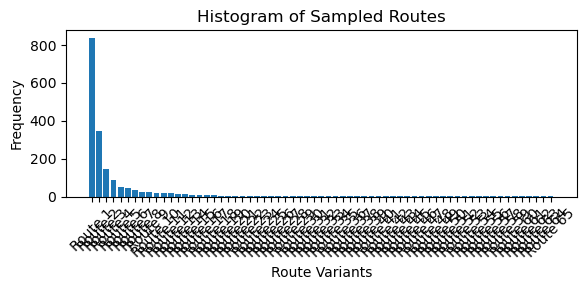

Total unique routes: 65
Most common route appeared 836 times
Top 10 most common routes:
1. EGLL CPT5J WOD BPK CLN L620 REDFA SLV SLV2J UKBB - 836 occurrences (46.5%)
2. EGLL CPT5J WOD BPK Q295 MATCH CLN L620 REDFA SLV SLV2J UKBB - 349 occurrences (19.4%)
3. EGLL CPT5J WOD BPK Q295 BRAIN M197 GASBA M189 CLN L620 REDFA SLV SLV2J UKBB - 148 occurrences (8.2%)
4. EGLL CPT5J WOD BPK Q295 BRAIN P44 CLN L620 REDFA SLV SLV2J UKBB - 89 occurrences (4.9%)
5. EGLL CPT5J WOD BPK CLN P44 RATLO M197 REDFA SLV SLV2J UKBB - 53 occurrences (2.9%)
6. EGLL CPT5J WOD BPK CLN L620 REDFA OMAVA L980 USTIL SLV SLV2J UKBB - 47 occurrences (2.6%)
7. EGLL CPT5J WOD BPK CLN L620 REDFA BALBA T425 USTIL SLV SLV2J UKBB - 36 occurrences (2.0%)
8. EGLL CPT5J WOD BPK Q295 MATCH CLN P44 RATLO M197 REDFA SLV SLV2J UKBB - 23 occurrences (1.3%)
9. EGLL CPT5J WOD BPK Q295 BRAIN P44 DAGGA M604 GASBA M189 CLN L620 REDFA SLV SLV2J UKBB - 23 occurrences (1.3%)
10. EGLL CPT5J WOD BPK Q295 MATCH CLN L620 REDFA BALBA T425 USTIL SL

In [7]:
formatted_sampled_routes = [format_flightplan(get_detailed_flightplan_from_waypoint_list(route_graph, route)) for route in sampled_routes]
import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each unique route
route_counts = Counter(formatted_sampled_routes)

# Sort routes by frequency (most common first)
sorted_routes = route_counts.most_common()

# Extract routes and their counts
routes = [route for route, _ in sorted_routes]
counts = [count for _, count in sorted_routes]

# Create the histogram
plt.figure(figsize=(6, 3))
plt.bar(range(len(routes)), counts)
plt.xlabel('Route Variants')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Routes')

# If there are many routes, limit the x-axis labels to avoid overcrowding
if len(routes) > 10:
    plt.xticks(range(len(routes)), [f"Route {i+1}" for i in range(len(routes))], rotation=45)
    # Show the actual routes for the top 5 most common
    for i in range(min(5, len(routes))):
        pass
        # plt.annotate(f"{routes[i][:30]}...", 
        #              xy=(i, counts[i]), 
        #              xytext=(0, 5),
        #              textcoords="offset points",
        #              ha='center', va='bottom',
        #              rotation=45)
    # plt.figtext(0.5, 0.01, "Note: Only labels for top 5 routes are shown", ha='center')
else:
    plt.xticks(range(len(routes)), routes, rotation=45)

plt.tight_layout()
plt.show()

# Print statistics about the sampled routes
print(f"Total unique routes: {len(route_counts)}")
print(f"Most common route appeared {route_counts.most_common(1)[0][1]} times")
print(f"Top 10 most common routes:")
for i, (route, count) in enumerate(route_counts.most_common(10)):
    print(f"{i+1}. {route} - {count} occurrences ({count/len(formatted_sampled_routes)*100:.1f}%)")


In [ ]:
# Get the least common route
least_common_route, count = route_counts.most_common()[-10]
print(f"Least common route: {least_common_route} - appeared {count} times")

# C++ version

In [20]:
sys.path.append(os.path.join(PROJECT_ROOT, "lateral", "splicer"))
import splicer as splicer

In [21]:
def convert_to_splicer_graph(route_graph):
    """
    Convert a route graph to a splicer graph.
    
    Parameters:
    -----------
    route_graph : dict or object
        The route graph to convert. Expected to have:
        - nodes: dict with node_id as key and {'x': x_coord, 'y': y_coord} as value
        - edges: list of tuples (from_node, to_node, weight)
        
    Returns:
    --------
    splicer.Graph
        The converted splicer graph
    """
    # Create a new splicer graph
    graph = splicer.Graph()
    
    # Add nodes to the splicer graph
    for node_id, coords in route_graph.nodes.items():
        graph.add_node(node_id, coords['lat'], coords['lon'])
    
    # Add edges to the splicer graph
    for from_node, to_node in route_graph.edges:
        weight = route_graph.edges[from_node, to_node]['distance']
        graph.add_edge(from_node, to_node, weight)
    
    return graph

splicer_graph = convert_to_splicer_graph(route_graph)

In [ ]:
# Run MCMC
sampled_routes, final_route, total_accepted, acceptance_rate = splicer.start_mcmc(
    splicer_graph, shortest_path, temperature=10, max_iter=30_000, burn_in=5_000, thinning=25, verbose=False
)

print(f"Final route: {final_route}")